In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import xgboost as xgb
from functools import reduce
%matplotlib inline

In [2]:
df=pd.read_csv(r"D:\ML\xgboost_test\customer_churn_dataset.csv")

In [3]:
df.columns=df.columns.str.replace(" ","_",regex=True)
df.columns

Index(['Unnamed:_0', 'Customer_ID', 'demo_count', 'Country', 'State', 'City',
       'Zip_Code', 'Lat_Long', 'Latitude', 'Longitude', 'Gender',
       'Senior_Citizen', 'Dependents', 'Tenure_in_Months', 'Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection_Plan', 'Premium_Tech_Support',
       'Streaming_TV', 'Streaming_Movies', 'Contract', 'Paperless_Billing',
       'Payment_Method', 'Monthly_Charge', 'Total_Charges', 'Churn_Label',
       'Churn_Value', 'Churn_Score', 'CLTV', 'Churn_Reason'],
      dtype='object')

In [4]:
def drop_constants(df,col_list=['Customer_ID','Unnamed:_0']):
    col_list.extend([x for x in list(df.columns) if df[x].nunique()==1])
    print(f"dropping consant cols: {col_list} ")
    df.drop(columns=col_list,inplace=True)
    return df


In [5]:
#dropping ids cols, constant and quasi constant cols
df=drop_constants(df)

dropping consant cols: ['Customer_ID', 'Unnamed:_0', 'demo_count', 'Country', 'State'] 


In [6]:
df.drop('Lat_Long',axis=1, inplace=True)

In [7]:
df['City'].replace(" ","_", regex=True, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   City                    7043 non-null   object 
 1   Zip_Code                7043 non-null   int64  
 2   Latitude                7043 non-null   float64
 3   Longitude               7043 non-null   float64
 4   Gender                  7043 non-null   object 
 5   Senior_Citizen          7043 non-null   object 
 6   Dependents              7043 non-null   object 
 7   Tenure_in_Months        7043 non-null   int64  
 8   Phone_Service           7043 non-null   object 
 9   Multiple_Lines          7043 non-null   object 
 10  Internet_Service        7043 non-null   object 
 11  Online_Security         7043 non-null   object 
 12  Online_Backup           7043 non-null   object 
 13  Device_Protection_Plan  7043 non-null   object 
 14  Premium_Tech_Support    7043 non-null   

In [9]:
categorical_cols=df.select_dtypes(include="object").columns.to_list()
categorical_cols

['City',
 'Gender',
 'Senior_Citizen',
 'Dependents',
 'Phone_Service',
 'Multiple_Lines',
 'Internet_Service',
 'Online_Security',
 'Online_Backup',
 'Device_Protection_Plan',
 'Premium_Tech_Support',
 'Streaming_TV',
 'Streaming_Movies',
 'Contract',
 'Paperless_Billing',
 'Payment_Method',
 'Churn_Label',
 'Churn_Reason']

c:\Users\ravik\anaconda3\envs\ml_engine\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Churn_Label', ylabel='Count'>

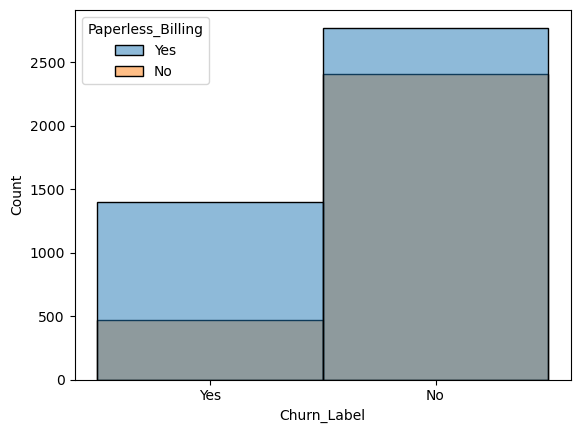

In [10]:

sns.histplot(data=df,x='Churn_Label',hue='Paperless_Billing')

In [11]:
df['Churn_Label'].value_counts()

Churn_Label
No     5174
Yes    1869
Name: count, dtype: int64

In [12]:
df.groupby(['Churn_Label','Paperless_Billing']).agg({'Paperless_Billing':'count'})

Paperless_Billing
Churn_Label Paperless_Billing                   
No          No                              2403
            Yes                             2771
Yes         No                               469
            Yes                             1400

c:\Users\ravik\anaconda3\envs\ml_engine\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ravik\anaconda3\envs\ml_engine\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


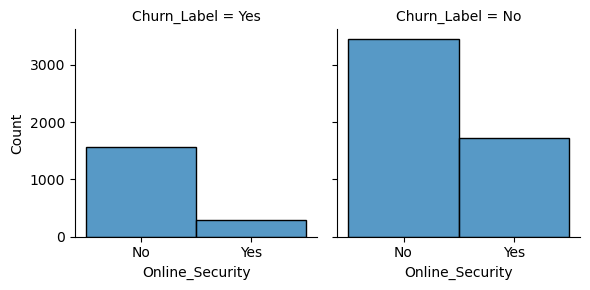

In [13]:
grids=sns.FacetGrid(df,col='Churn_Label')
grids.map(sns.histplot,'Online_Security')


In [14]:
test=df.pivot_table(index="Churn_Label",columns="Paperless_Billing",aggfunc={'Paperless_Billing':lambda x : len(x)/len(df['Paperless_Billing'])*100})

<Axes: xlabel='Churn_Label'>

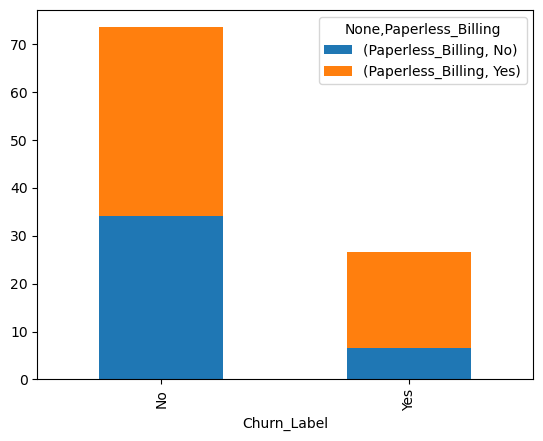

In [15]:
test.plot(kind='bar',stacked=True)

In [28]:
def get_stacked_plots(columns,super_title):
   cols = 2
   rows=len(columns)//2
   
   #creating a figure 
   fig = plt.figure(figsize=(12,6*rows))
   fig.suptitle(super_title, fontsize=22)


   #iterating each col to be plotted along with index
   for idx,col in enumerate(columns,1):
      axes=fig.add_subplot(rows,cols,idx)
      feature_proportion = pd.pivot_table(df,index=col,columns='Churn_Label',aggfunc={'Churn_Label':lambda x : len(x)/len(df['Churn_Label'])*100})
      feature_proportion.plot(kind='bar',ax=axes,stacked=True)
      axes.set_title(f"proportion of observations w.r.t {col}")


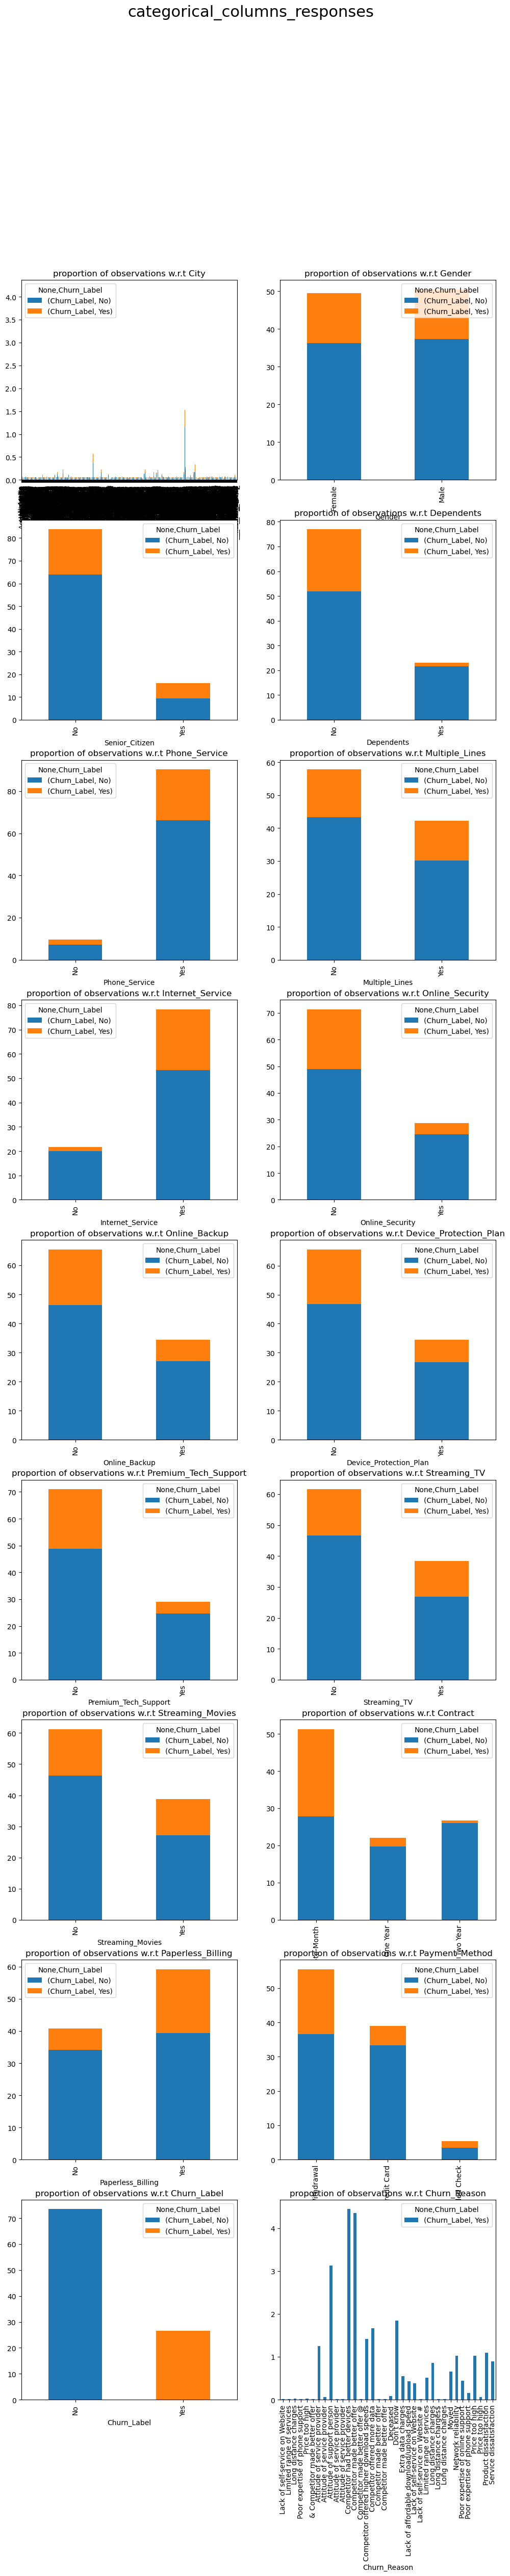

In [29]:
get_stacked_plots(categorical_cols,"categorical_columns_responses")